# Latent Semantic Analysis of a corpus

# Simple Example

In [2]:
noise_list = ["is", "a", "this", "..."] 
def _remove_noise(input_text):
    words = input_text.split() 
    noise_free_words = [word for word in words if word not in noise_list] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

_remove_noise("this is a sample text")

'sample text'

# Base path for the ACL IMDB data set

In [3]:
# Load all the reviews into data frames.
base_path = "/Users/hujol/Projects/advanced_analytics_spark/data/aclImdb/"

# Loading the files into a data frame

In [4]:
import re
from datetime import datetime
from pathlib import Path
import shutil

# RegEx for extracting file information.
prog = re.compile('(.*)_(.*)\.txt')

# Labels.
labels = { 'pos': 1, 'neg':0}

# Here for the sake of short testing without loading the whole data in Spark.
ttl = 100000 # 50000
ttl_h = ttl / 2

# Try to get half of positives and negatives from ttl since my pc cannot load the total 55K reviews!
ttl_positives = 0
ttl_negatives = 0

cnt = 0

# Features description.
features = ['datasettype', 'filename', 'datetimecreated', 'reviewid', 'reviewpolarity', 'reviewrating', 'text']

# The context.
sc = spark.sparkContext

# The complete data frame built from all the files.
df = None

# Keep track of when the data set was built.
utcdate = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

entries = []

# Find all review files.
for set_name in ('test', 'train'):
    for sa_name in ('neg', 'pos'):
        dir_path = os.path.join(base_path, set_name, sa_name)
        
        polarity = labels[sa_name]
        
        if ('neg' == sa_name and ttl_negatives > ttl_h): break;
        
        if ('pos' == sa_name and ttl_positives > ttl_h): break;
        
        # Load each review file.
        for file in os.listdir(dir_path):
            # Extract the ID and the rating of the review from the file name.
            m = prog.match(file)
            id = int(m.group(1))
            rating = int(m.group(2))
            
            # Read in the review.
            with open(os.path.join(dir_path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                
            # Prepare the entry
            entry = [set_name, file, utcdate, id, int(polarity), int(rating), txt]
            entries.append(entry)
        
            # Loop checking.
            cnt += 1
            if (cnt == ttl): break

            if ('neg' == sa_name): ttl_negatives += 1
            if ('neg' == sa_name and ttl_negatives > ttl_h): break;

            if ('pos' == sa_name): ttl_positives += 1
            if ('pos' == sa_name and ttl_positives > ttl_h): break;
                
        if (cnt == ttl): break
    if (cnt == ttl): break

# Process the entries.
sa_rdd = sc.parallelize(entries)
df = sa_rdd.toDF(features)
        
# Store the DF in parquet format.
file_pqt = os.path.join(base_path, ("aclImdb_%s_raw.parquet" % ttl))

# If the parquet directory exists, remove it.
if Path(file_pqt).is_dir():
    shutil.rmtree(file_pqt)

df.write.parquet(file_pqt)

# Store as CVS

In [5]:
import numpy as np

# Define the CSV file.
file_csv = os.path.join(base_path, ("aclImdb_%s.csv" % ttl))

# Get the data as Pandas data frame.
pdf = df.toPandas()

# Re index to shuffle the data before saving it.
pdf = pdf.reindex(np.random.permutation(pdf.index))
pdf.to_csv(file_csv, index=False, encoding='utf-8')

# Load the CSV file for checking data is stored

In [58]:
import pandas as pd

ttl = 100000

# Define the CSV file.
file_csv = os.path.join(base_path, ("aclImdb_%s.csv" % ttl))

pdf_read = pd.read_csv(file_csv, encoding='utf-8')
pdf_read[1:3]

,datasettype,filename,datetimecreated,reviewid,reviewpolarity,reviewrating,text
1,test,9487_1.txt,20181022T102331Z,9487,0,1,I have seen this movie and I did not care for ...
2,test,4604_4.txt,20181022T102331Z,4604,0,4,"In Los Angeles, the alcoholic and lazy Hank Ch..."


In [7]:
df_csv = spark.createDataFrame(pdf_read)
df_csv.show()

+-----------+-----------+----------------+--------+--------------+------------+--------------------+
|datasettype|   filename| datetimecreated|reviewid|reviewpolarity|reviewrating|                text|
+-----------+-----------+----------------+--------+--------------+------------+--------------------+
|       test| 1821_4.txt|20181022T102331Z|    1821|             0|           4|Alan Rickman & Em...|
|       test| 9487_1.txt|20181022T102331Z|    9487|             0|           1|I have seen this ...|
|       test| 4604_4.txt|20181022T102331Z|    4604|             0|           4|In Los Angeles, t...|
|       test| 2828_2.txt|20181022T102331Z|    2828|             0|           2|This film is bund...|
|       test|10890_1.txt|20181022T102331Z|   10890|             0|           1|I only comment on...|
|       test| 3351_4.txt|20181022T102331Z|    3351|             0|           4|When you look at ...|
|       test| 8070_2.txt|20181022T102331Z|    8070|             0|           2|Rollerskatin

In [8]:
df_csv.printSchema()

root
 |-- datasettype: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- datetimecreated: string (nullable = true)
 |-- reviewid: long (nullable = true)
 |-- reviewpolarity: long (nullable = true)
 |-- reviewrating: long (nullable = true)
 |-- text: string (nullable = true)



# Load the data from the parquet file

In [9]:
# Check the parquet file is good.
ttl = 100000 #200
file_pqt = os.path.join(base_path, ("aclImdb_%s_raw.parquet" % ttl))

df_pqt = spark.read.parquet(file_pqt)

# As needed.
# df_pqt = df_pqt.drop('words')

# Showing some observations (entries).
df_pqt.persist()
df_pqt.show()

+-----------+------------+----------------+--------+--------------+------------+--------------------+
|datasettype|    filename| datetimecreated|reviewid|reviewpolarity|reviewrating|                text|
+-----------+------------+----------------+--------+--------------+------------+--------------------+
|      train|  9670_9.txt|20181022T102331Z|    9670|             1|           9|One of the best m...|
|      train|  8747_7.txt|20181022T102331Z|    8747|             1|           7|*Possible Spoiler...|
|      train| 5194_10.txt|20181022T102331Z|    5194|             1|          10|This is one of my...|
|      train|  1725_8.txt|20181022T102331Z|    1725|             1|           8|Playing out as a ...|
|      train|  6235_8.txt|20181022T102331Z|    6235|             1|           8|This is one of th...|
|      train|  4900_8.txt|20181022T102331Z|    4900|             1|           8|This is a quirky ...|
|      train| 10774_8.txt|20181022T102331Z|   10774|             1|           8|..

In [10]:
df_pqt.count()

50000

# Preprocessing the text to clean HTML tags

In [11]:
import re

def clean_html(text):
    res = re.sub('<.*/>', '', text)
    return  re.sub('[\W]+', ' ', res)

a_text = 'the secrets] of the universe. <br /><br />Unfortunately, '
print(a_text)
print(clean_html(a_text))

from pyspark.sql import Row 

from functools import partial

def preprocess(new_column_name, row):
    data = row.asDict()
    text = data['text']
    
    # Use a regex to clean HTML tags
    text = clean_html(text)
    data[new_column_name] = text
    
    return Row(**data)

def transform_html_clean(df, new_column_name):
    f = partial(preprocess, new_column_name)
    return df.rdd.map(f).toDF()

the secrets] of the universe. <br /><br />Unfortunately, 
the secrets of the universe Unfortunately 


In [60]:
# Clean the parquet data frame.
df_pqt = transform_html_clean(df_pqt, 'textclean')
df_pqt.select('text', 'textclean').take(2)

[Row(text="One of the best movies I ever saw was an Irish movie titled Philadelphia,Here I Come. I read the play before I saw the movie and loved them both. It's the story of a young man preparing to leave Ireland to go to America because he can't earn a living in Ireland. It is told both from the perspective of the young man(whom the other characters in the film can see) and another young man representing his uncensored thoughts and feelings., but who cannot be seen by the other characters in the film. It is a very sad movie, but deeply touching, and I would recommend this film to anyone who wants something to think about. I love any Irish movie, or almost any movie about Ireland, and any film that has the late Irish actor Donal McCann in it gets my vote.I would watch that man chew gum for 2 hours on screen, and unfortunately,I have.Terrible shame to have lost him so young.", textclean='One of the best movies I ever saw was an Irish movie titled Philadelphia Here I Come I read the pla

# Stemming and Lemmatization of text

## Example using NLTK

In [13]:
import nltk
from nltk.stem import PorterStemmer

words = ['write','writer','writing','writers']
ps = PorterStemmer()

for word in words:
    print(f"{word}: {ps.stem(word)}")

write: write
writer: writer
writing: write
writers: writer


In [14]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

lemmatizer.lemmatize('dogs')

[nltk_data] Downloading package wordnet to /Users/hujol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'dog'

## Spark Features Extractor Bag of Words

In [15]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

df_pqt = df_pqt.drop('words')
            
tokenizer = Tokenizer(inputCol="textclean", outputCol="words")
df_pqt = tokenizer.transform(df_pqt)

df_pqt.select('words').take(1)

# hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
# featurizedData = hashingTF.transform(wordsData)
# # alternatively, CountVectorizer can also be used to get term frequency vectors

# idf = IDF(inputCol="rawFeatures", outputCol="features")
# idfModel = idf.fit(featurizedData)
# rescaledData = idfModel.transform(featurizedData)
# for features_label in rescaledData.select("features", "label").take(3):
#     print(features_label)

[Row(words=['one', 'of', 'the', 'best', 'movies', 'i', 'ever', 'saw', 'was', 'an', 'irish', 'movie', 'titled', 'philadelphia', 'here', 'i', 'come', 'i', 'read', 'the', 'play', 'before', 'i', 'saw', 'the', 'movie', 'and', 'loved', 'them', 'both', 'it', 's', 'the', 'story', 'of', 'a', 'young', 'man', 'preparing', 'to', 'leave', 'ireland', 'to', 'go', 'to', 'america', 'because', 'he', 'can', 't', 'earn', 'a', 'living', 'in', 'ireland', 'it', 'is', 'told', 'both', 'from', 'the', 'perspective', 'of', 'the', 'young', 'man', 'whom', 'the', 'other', 'characters', 'in', 'the', 'film', 'can', 'see', 'and', 'another', 'young', 'man', 'representing', 'his', 'uncensored', 'thoughts', 'and', 'feelings', 'but', 'who', 'cannot', 'be', 'seen', 'by', 'the', 'other', 'characters', 'in', 'the', 'film', 'it', 'is', 'a', 'very', 'sad', 'movie', 'but', 'deeply', 'touching', 'and', 'i', 'would', 'recommend', 'this', 'film', 'to', 'anyone', 'who', 'wants', 'something', 'to', 'think', 'about', 'i', 'love', 'any

## Text cleansing

In [16]:
import nltk
from nltk.corpus import stopwords

# Remove the stop words
nltk.download('stopwords')
stopwords_bc = spark.sparkContext.broadcast(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/hujol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def row_text_cleaner(words):
    words_clean = []
    for a_w in words:
        if not a_w in stopwords_bc.value:
            words_clean.append(a_w)
    
    # Return the cleaned words.
    return words_clean

test_words = ['it', 'is', 'great', 'you', 'have', 'been', 'kitesurfing', 'that', 'long']
row_text_cleaner(test_words)

['great', 'kitesurfing', 'long']

In [18]:
from pyspark.sql import Row 

def f(x):
    data = x.asDict()
    data['wordsclean'] = row_text_cleaner(x.words)
    
    # The purpose of ** is to give the ability to feed a function's arguments 
    # by providing a dictionary (e.g. f(**{'x' : 1, 'y' : 2}) ).
    return Row(**data)

# NOTE:
# There is a need to store the result into df_pqt2 otherwise the
# added words_clean added column does not show well if we store it in the same df_pqt when running:
# df_pqt.select('words_clean').show()
rdd_tmp = df_pqt.rdd.map(f)
df_pqt = rdd_tmp.toDF()

df_pqt.select('wordsclean').show()

+--------------------+
|          wordsclean|
+--------------------+
|[one, best, movie...|
|[, possible, spoi...|
|[one, favourite, ...|
|[playing, sort, p...|
|[one, best, fred,...|
|[quirky, movie, b...|
|[, importance, yo...|
|[moon, child, sta...|
|[four, teenage, g...|
|[seen, movie, man...|
|[first, let, star...|
|[riding, giantsa,...|
|[movie, well, don...|
|[, kaabee, depict...|
|[huge, ramones, f...|
|[great, deal, mat...|
|[loved, movie, sa...|
|[film, beauty, ha...|
|[previous, review...|
|[watched, movie, ...|
+--------------------+
only showing top 20 rows



In [19]:
# Remove intermediairy data not needed anymore.
df_pqt.printSchema()
# df_pqt = df_pqt.withColumnRenamed('words_clean', 'words')
df_pqt = df_pqt.drop('textclean')
df_pqt.printSchema()

root
 |-- datasettype: string (nullable = true)
 |-- datetimecreated: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- reviewid: long (nullable = true)
 |-- reviewpolarity: long (nullable = true)
 |-- reviewrating: long (nullable = true)
 |-- text: string (nullable = true)
 |-- textclean: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- wordsclean: array (nullable = true)
 |    |-- element: string (containsNull = true)

root
 |-- datasettype: string (nullable = true)
 |-- datetimecreated: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- reviewid: long (nullable = true)
 |-- reviewpolarity: long (nullable = true)
 |-- reviewrating: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- wordsclean: array (nullable = true)
 |    |-- element: string (containsNull = true)



# Computation of the TF-IDF

## HashingTF testing on small vocabulary

In [20]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = spark.createDataFrame([
    (0, "Hi I heard about Spark and I love SPark with Java, I read a lot about java and spark, sparky!"),
    (0, "I wish Java could use case classes"),
    (1, "Logistic regression models are neat")
], ["label", "sentence"])
tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

# This uses the hash and the modulo numFeatures to define a bucket where to put a word.
# It is efficient as it does not store the vocabulary.
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5096)
featurizedData = hashingTF.transform(wordsData)

featurizedData.select('words', 'rawFeatures').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                             |rawFeatures                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|[hi, i, heard, about, spark, and, i, love, spark, with, java,, i, read, a, lot, about, java, and, spark,, sparky!]|(5096,[56,338,565,677,1568,1722,2321,2455,2799,2905,3001,3202,4672,4673,4959],[1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0

## CountVectorizer test on small data frame

In [21]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="words", outputCol="rawfeatures", vocabSize=70, minDF=1.0)
model = cv.fit(featurizedData)
result = model.transform(featurizedData)

In [22]:
result.select('rawfeatures', 'words').head()

Row(rawfeatures=SparseVector(25, {0: 3.0, 1: 2.0, 2: 1.0, 3: 2.0, 4: 2.0, 5: 1.0, 7: 1.0, 9: 1.0, 12: 1.0, 14: 1.0, 17: 1.0, 19: 1.0, 20: 1.0, 22: 1.0, 23: 1.0}), words=['hi', 'i', 'heard', 'about', 'spark', 'and', 'i', 'love', 'spark', 'with', 'java,', 'i', 'read', 'a', 'lot', 'about', 'java', 'and', 'spark,', 'sparky!'])

# TF-IDF on reviews

In [23]:
from pyspark.ml.feature import CountVectorizer

df_pqt = df_pqt.drop('featurestf')
cv = CountVectorizer(inputCol="wordsclean", outputCol="featurestf", vocabSize=30000, minDF=1.0)
model_cv = cv.fit(df_pqt)
df_pqt = model_cv.transform(df_pqt)

In [24]:
print("Number of unique words in the corpus: %s" % len(model_cv.vocabulary))
print("Excerpt of the vocabulary\n" + str(model_cv.vocabulary[1:100]))

# result.select('features').rdd.map(lambda x: print(x)).take(1)

Number of unique words in the corpus: 30000
Excerpt of the vocabulary
['film', 'one', 'like', 'good', 'time', 'see', 'would', 'even', 'really', 'story', 'well', 'great', 'bad', 'much', 'movies', 'people', 'first', 'get', 'made', 'watch', 'also', 'make', 'seen', 'could', 'films', 'way', 'think', 'ever', 'best', 'love', 'many', 'show', 'acting', 'never', 'characters', 'plot', 'better', 'life', 'two', 'know', 'little', 'say', '10', 'still', 'character', 'watching', 'man', 'end', 'something', 'go', 'years', 'funny', 'back', 'scenes', 'actors', 'director', 'thing', 'real', 'scene', 'old', 'though', 'find', 'lot', 'work', 'nothing', 'horror', 'another', 'actually', 'want', 'look', 'saw', 'every', 'new', 'going', 'makes', 'thought', 'cast', 'give', 'got', 'part', 'pretty', 'comedy', 'world', 'quite', 'must', 'series', 'big', 'us', 'long', 'things', 'original', 'however', 'take', 'enough', 'young', 'may', 'tv', 'always', 'worst']


In [25]:
df_pqt.take(1)[0].featurestf

SparseVector(30000, {0: 5.0, 1: 4.0, 2: 1.0, 6: 1.0, 7: 2.0, 10: 1.0, 15: 1.0, 20: 1.0, 23: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 35: 2.0, 47: 4.0, 49: 1.0, 50: 1.0, 67: 1.0, 71: 2.0, 95: 4.0, 103: 1.0, 110: 1.0, 111: 1.0, 124: 1.0, 134: 1.0, 156: 1.0, 158: 1.0, 179: 1.0, 188: 1.0, 190: 1.0, 227: 1.0, 242: 1.0, 315: 1.0, 355: 1.0, 361: 1.0, 420: 1.0, 426: 1.0, 449: 1.0, 462: 1.0, 467: 1.0, 469: 1.0, 474: 1.0, 615: 1.0, 695: 1.0, 1119: 1.0, 1335: 1.0, 1523: 1.0, 1799: 1.0, 1937: 1.0, 2203: 1.0, 2340: 3.0, 3113: 1.0, 3544: 3.0, 6156: 1.0, 6342: 1.0, 6429: 1.0, 7656: 1.0, 9227: 1.0, 9847: 1.0, 14618: 1.0, 20976: 1.0, 24773: 1.0})

## IDF

In [26]:
from pyspark.ml.feature import IDF

# Drop the column first.
df_pqt = df_pqt.drop('featuresidf')

# IDF uses a term frequency vector:
# http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=tfidf#pyspark.mllib.feature.IDF
idf = IDF(inputCol="featurestf", outputCol="featuresidf")
idfModel = idf.fit(df_pqt)
df_pqt = idfModel.transform(df_pqt)

df_pqt.persist()

DataFrame[datasettype: string, datetimecreated: string, filename: string, reviewid: bigint, reviewpolarity: bigint, reviewrating: bigint, text: string, words: array<string>, wordsclean: array<string>, featurestf: vector, featuresidf: vector]

In [27]:
df_pqt.select('reviewpolarity', "reviewrating", "featuresidf", 'text').take(1)

[Row(reviewpolarity=1, reviewrating=9, featuresidf=SparseVector(30000, {0: 3.1463, 1: 3.0069, 2: 0.8302, 6: 1.4339, 7: 2.9738, 10: 1.5891, 15: 1.7805, 20: 1.7708, 23: 1.831, 27: 1.9148, 28: 1.9333, 29: 1.9827, 30: 2.0803, 35: 4.1522, 47: 9.2522, 49: 2.2445, 50: 2.2376, 67: 2.423, 71: 4.9204, 95: 10.8737, 103: 2.7365, 110: 2.6847, 111: 2.7028, 124: 2.7596, 134: 2.8313, 156: 2.8961, 158: 2.9783, 179: 3.0713, 188: 3.1508, 190: 3.1127, 227: 3.2655, 242: 3.2597, 315: 3.4712, 355: 3.5227, 361: 3.5649, 420: 3.7508, 426: 3.7406, 449: 3.781, 462: 3.7679, 467: 3.7889, 469: 3.7881, 474: 3.8286, 615: 4.041, 695: 4.1734, 1119: 4.5933, 1335: 4.8359, 1523: 4.9533, 1799: 5.1534, 1937: 5.2401, 2203: 5.3517, 2340: 17.0169, 3113: 5.8025, 3544: 18.5552, 6156: 6.7089, 6342: 6.6609, 6429: 6.7255, 7656: 6.9486, 9227: 7.1822, 9847: 7.3233, 14618: 7.8754, 20976: 8.6226, 24773: 8.8739}), text="One of the best movies I ever saw was an Irish movie titled Philadelphia,Here I Come. I read the play before I saw the 

# Training a logistic regression for Sentiment Analysis

### Logistic regression model using N-fold stratified cross-validation

In [63]:
import nltk
from nltk.corpus import stopwords

# Remove the stop words
nltk.download('stopwords')
stopwords_set = list(set(stopwords.words('english')))

stopwords_set[1:20]
# stopwords_bc = spark.sparkContext.broadcast(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/hujol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'being',
 'off',
 'haven',
 'few',
 'up',
 'while',
 "it's",
 'those',
 'is',
 'same',
 'mustn',
 'in',
 've',
 'hers',
 'all',
 'above',
 'very',
 'they']

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Create a test df.
df0 = transform_html_clean(df_pqt, 'textclean')

tokenizer = Tokenizer(inputCol="textclean", outputCol="words_tknz")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words_test", stopWords=stopwords_set)
pipeline = Pipeline(stages=[tokenizer, remover])

len(pipeline.fit(df0).transform(df0).head().words_test)

82

In [30]:
# Split the df into train and test
df_training, df_test = df_pqt.randomSplit([0.9, 0.1], seed=12345)

df_training.count(), df_test.count()

(45043, 4957)

In [31]:
df_training.groupBy('reviewpolarity').count().show()
df_test.groupBy('reviewpolarity').count().show()

+--------------+-----+
|reviewpolarity|count|
+--------------+-----+
|             0|22625|
|             1|22418|
+--------------+-----+

+--------------+-----+
|reviewpolarity|count|
+--------------+-----+
|             0| 2375|
|             1| 2582|
+--------------+-----+



In [32]:
df_training = df_training.drop('words')
df_training = df_training.drop('featurestf')

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator , RegressionEvaluator
from pyspark.ml.feature import StopWordsRemover, HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Based on Spark doc
# https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation

# Define the stages.
tokenizer = Tokenizer(inputCol="textclean", outputCol="words_tknz")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words", stopWords=stopwords_set)

# The idea is to create a features vector from a list of words.

# 1) Use this hashing Term Frequency.
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")

# Or 2) use the Term Frequency - Inverse Document Frequency.
cv = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="featurestf", vocabSize=30000, minDF=1.0)
idf = IDF(inputCol=cv.getOutputCol(), outputCol="features")

lr = LogisticRegression(maxIter=10)

# Create the pipeline.
pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, lr])

# Define the criteria ranges.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 50000, 200000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# The evaluator of each models.
# evaluator = RegressionEvaluator(metricName="r2")
evaluator = BinaryClassificationEvaluator()

# Define the cross validation runner.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
df_training_tmp = df_training.withColumnRenamed('reviewpolarity', 'label')
df_training_ppl = transform_html_clean(df_training_tmp, 'textclean')

# Train the model.
cvModel = crossval.fit(df_training_ppl)

In [34]:
cvModel.avgMetrics

[0.9306365250129929,
 0.9192822909849401,
 0.9305837407495565,
 0.9192582717589457,
 0.9306982633744618,
 0.9190437984787838]

In [35]:
model_best = cvModel.bestModel

In [36]:
df_training_pip = model_best.transform(df_training_ppl)
eval_val = evaluator.evaluate(df_training_pip)
print(evaluator.isLargerBetter())
print(eval_val)

True
0.9957316580155462


In [55]:
df_training_pip.filter(df_training_pip.label == df_training_pip.prediction) \
    .select('label', 'probability', 'prediction', 'words').take(2)

[Row(label=1, probability=DenseVector([0.1814, 0.8186]), prediction=1.0, words=['brilliant', 'acting', 'lesley', 'ann', 'warren', 'best', 'dramatic', 'hobo', 'lady', 'ever', 'seen', 'love', 'scenes', 'clothes', 'warehouse', 'second', 'none', 'corn', 'face', 'classic', 'good', 'anything', 'blazing', 'saddles', 'take', 'lawyers', 'also', 'superb', 'accused', 'turncoat', 'selling', 'boss', 'dishonest', 'lawyer', 'pepto', 'bolt', 'shrugs', 'indifferently', 'lawyer', 'says', 'three', 'funny', 'words', 'jeffrey', 'tambor', 'favorite', 'later', 'larry', 'sanders', 'show', 'fantastic', 'mad', 'millionaire', 'wants', 'crush', 'ghetto', 'character', 'malevolent', 'usual', 'hospital', 'scene', 'scene', 'homeless', 'invade', 'demolition', 'site', 'time', 'classics', 'look', 'legs', 'scene', 'two', 'big', 'diggers', 'fighting', 'one', 'bleeds', 'movie', 'gets', 'better', 'time', 'see', 'quite', 'often']),
 Row(label=1, probability=DenseVector([0.1532, 0.8468]), prediction=1.0, words=['easily', 'und

## Evaluation of the cross validation model

In [38]:
df_test = df_test.drop('featurestf')
df_test = df_test.drop('words')

In [54]:
# Prepare data.
df_test_tmp = df_test.withColumnRenamed('reviewpolarity','label')
df_test_ppl = transform_html_clean(df_test_tmp, 'textclean')

# Make prediction.
df_test_res = model_best.transform(df_test_ppl)
df_test_res.select('probability', 'label','prediction', 'features', 'words').take(2)

[Row(probability=DenseVector([0.385, 0.615]), label=1, prediction=1.0, features=SparseVector(30000, {1: 0.7496, 91: 2.6101, 105: 2.7464, 129: 2.7892, 162: 3.0012, 167: 3.0567, 192: 3.2199, 254: 3.27, 264: 3.2924, 304: 3.4265, 339: 3.4848, 367: 3.5561, 443: 3.7608, 514: 3.9515, 539: 3.8932, 625: 4.0927, 815: 4.6309, 1000: 4.4771, 1212: 4.6968, 1503: 4.9224, 1625: 5.2182, 1632: 5.3172, 1937: 5.5059, 2187: 5.528, 2455: 5.5336, 2660: 5.6155, 2665: 5.7114, 2861: 6.0333, 3027: 5.9618, 3212: 6.1615, 3321: 5.9969, 3554: 5.9032, 3967: 6.052, 4142: 6.1003, 5727: 6.9542, 6874: 7.16, 6910: 6.7642, 8610: 7.0778, 9627: 7.3832, 10766: 7.771, 11138: 7.771, 12134: 7.771, 12480: 7.825, 20053: 8.5182, 25955: 8.9236}), words=['night', 'listener', '2006', '1', '2', 'robin', 'williams', 'toni', 'collette', 'bobby', 'cannavale', 'rory', 'culkin', 'joe', 'morton', 'sandra', 'oh', 'john', 'cullum', 'lisa', 'emery', 'becky', 'ann', 'baker', 'dir', 'patrick', 'stettner', 'however', 'film', 'runs', 'gas', 'eventu

In [40]:
print(evaluator.evaluate(df_test_res))
# df_test_res.filter(df_test_res.label == df_test_res.prediction) \
#     .select('label', 'probability', 'prediction', 'features', 'words').show()

0.9332059195238258


# Confusion Matrix

In [41]:
from pyspark.mllib.evaluation import MulticlassMetrics

rdd_training_pip = df_training_pip.select('prediction', 'label').rdd.map(lambda row: (row[0], float(row[1])))
rdd_training_pip.take(2)

# print(rdd_training_pip.toDF().toPandas().shape)

metrics = MulticlassMetrics(rdd_training_pip)
print(metrics.confusionMatrix().toArray())
print()
print(metrics.truePositiveRate(1.0))
print(metrics.falsePositiveRate(1.0))

[[21890.   735.]
 [  698. 21720.]]

0.9688643054688197
0.03248618784530387


# Receiver Operating Characteristics (ROC)

In [42]:
cvModel.bestModel.stages[-1]

LogisticRegression_46bd867292f80135c6d4

In [43]:
from pyspark.ml.classification import LogisticRegressionSummary

# Get the Logistic regression model to get the summary.
summary = cvModel.bestModel.stages[-1].summary
summary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.019894727451155322|
|                 0.0| 0.03987866892675528|
|                 0.0| 0.05986261040235525|
|                 0.0| 0.07980194486573289|
|                 0.0| 0.09974127932911053|
|                 0.0| 0.11968061379248818|
|                 0.0| 0.13970916228031047|
|                 0.0| 0.15969310375591042|
|                 0.0|  0.1797216522437327|
|                 0.0|  0.1997948077437773|
|                 0.0| 0.21973414220715495|
|                 0.0| 0.23891515746275316|
|                 0.0|  0.2588990989383531|
|                 0.0| 0.27906146846284235|
|                 0.0|   0.299134623962887|
|                 0.0| 0.31911856543848693|
|4.419889502762431E-5| 0.33901329288964227|
|4.419889502762431E-5| 0.35904184137746453|
|4.419889502762431E-5| 0.3791149

# Plot the ROC

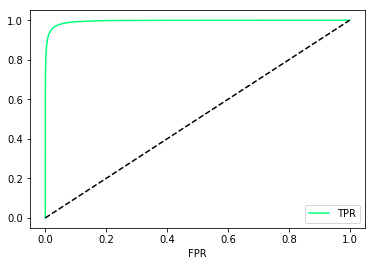

In [44]:
import matplotlib.pyplot as plt

# As defined by IPython matplotlib kernel
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html#id1
%matplotlib inline

aPlt = summary.roc.toPandas().plot(x='FPR', y='TPR', colormap='winter_r')
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='black')
plt.show()

# Stochastic Gradient Descent for online and out-of-core learning Using scikit-learn

In [45]:
# Use the df_csv loaded earlier.
print("%s entries from the CSV file" % df_csv.count())

50000 entries from the CSV file


In [46]:
# Define a generator to load the data from the file simulating a streaming.
ttl = 100000
file_csv = os.path.join(base_path, ("aclImdb_%s.csv" % ttl))

def stream_doc():
    with open(file_csv, 'r', encoding='utf-8') as csv:
        # skip header.
        next(csv)
        
        for line in csv:
            cells = line.split(',')
#             datasettype,filename,datetimecreated,reviewid,reviewpolarity,reviewrating,text = cells[0], \
#             cells[1], cells[2], cells[3], cells[4], cells[5], ",".join(cells[6:]).strip()

            filename,reviewpolarity,text = cells[1], cells[4], ",".join(cells[6:]).strip()

            yield filename,reviewpolarity,text

In [47]:
generator = stream_doc()
print(next(generator))
print(next(generator))

('1821_4.txt', '0', '"Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It\'s worth seeing for their scenes- and Rickman\'s scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook."')
('9487_1.txt', '0', 'I have seen this movie and I did not care for this movie anyhow. I would not think about going to Paris because I do not like this country and its national capital. I do not like to learn french anyhow because I do not understand their language. Why would I go to France when I rather go to Germany or t

In [48]:
# This function returns a number of documents (id, text) and their label from the doc stream.
def get_mini_batch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            filename,reviewpolarity,text = next(doc_stream)
            docs.append([filename, text])
            y.append(int(reviewpolarity))
    except StopIteration:
        return docs, y
    
    return docs, y

In [49]:
# Check the function we just wrote.
get_mini_batch(stream_doc(), 2)

([['1821_4.txt',
   '"Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It\'s worth seeing for their scenes- and Rickman\'s scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook."'],
  ['9487_1.txt',
   'I have seen this movie and I did not care for this movie anyhow. I would not think about going to Paris because I do not like this country and its national capital. I do not like to learn french anyhow because I do not understand their language. Why would I go to France when I rather go to Germany or 

# Example of SciKit Learn data set

In [50]:
from sklearn.datasets import load_boston
# from scipy.sparse.csr import csr_matrix

boston = load_boston()
print(type(boston.data[:]))

<class 'numpy.ndarray'>


In [51]:
# Create a pipeline.
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.evaluation import BinaryClassificationEvaluator , RegressionEvaluator
from pyspark.ml.feature import StopWordsRemover, HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the stages.
tokenizer = Tokenizer(inputCol="textclean", outputCol="words_tknz")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words", stopWords=stopwords_set)

# The idea is to create a features vector from a list of words.

# 1) Use this hashing Term Frequency.
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")

# Create the pipeline.
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF])

# The evaluator of each models.
# evaluator = RegressionEvaluator(metricName="r2")
evaluator = BinaryClassificationEvaluator()

# Stochastic Gradient Descent Using scikit-learn

In [65]:
from sklearn.linear_model import SGDClassifier
import numpy as np
from scipy.sparse.csr import csr_matrix

clf = SGDClassifier(loss="log", penalty="l2", max_iter=5, shuffle=True)

# Get the X and y labels.
def generate_X_y_labels(size):
    data_batch, labels_batch = get_mini_batch(data_stream, size)
    
    if not data_batch: return np.empty(), np.empty()
    
    df_batch = spark.createDataFrame(data_batch, ('id', 'text'))

    # Data cleansing.
    df_batch_clean = transform_html_clean(df_batch, 'textclean')
    df_training_tmp = df_batch_clean.withColumnRenamed('reviewpolarity', 'label')

    # Run the tokenizer and remover pipeline.
    m_pip = pipeline.fit(df_training_tmp)
    df_pip_batch = m_pip.transform(df_training_tmp)
    # Update the SGD regression weights.

    # Let's get the right shape for the SparseVector data into numpy arrays.
    series = df_pip_batch.toPandas()['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
    X = np.apply_along_axis(lambda x : x[0], 1, series)
    y_labels =  np.array(labels_batch)

    return X, y_labels

classes = np.array([0, 1])

# print(X[:])
# print(y_labels[1:10])

# Simulating a streaming
data_stream = stream_doc()

# Train the 45000 data from the entire data set.
for i in range(4):
    print("range %i" % i)
    X_train, y_labels_train = generate_X_y_labels(1000)
    if not len(X_train): break
        
    model_sgd = clf.partial_fit(X_train, y_labels_train, classes=classes)

# Test on the last 5000 entries.
X_test, y_labels_test = generate_X_y_labels(5000)

print(X_test)
if len(X_test):
    print("\nscore: %.3f" % model_sgd.score(X_test, y_labels_test))
else:
    print('No data')

# Train the model.

range 0


/Users/hujol/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


range 1
range 2
range 3
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

score: 1.000
